### 載入依賴

In [1]:
from configparser import ConfigParser
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from biomart import BiomartServer

from Models.DeltaBetaFilter import DeltaBetaFilter
from Models.CutpointCalculator import CutpointCalculator
from Models.GeneFilter import GeneFilter
from Models.AucCalculator import AucCalculator
from Models.GosemsimCalculator import GosemsimCalculator
from Models.CancerStageCalculator import CancerStageCalculator

from GOntoSim import GOntoSim
from MakeFile.FileSaver import FileSaver
from ValidateModel.ValidateData import ValidateData

  EXISTS: E:\Github\Methylation_analysis_prostate_cancer\GOntoSim\_resources\go-basic.obo
E:\Github\Methylation_analysis_prostate_cancer\GOntoSim\_resources\go-basic.obo: fmt(1.2) rel(2024-03-28) 51,463 Terms; optional_attrs(relationship replaced_by)


### 載入設定檔

In [2]:
_configPath = "config.ini"
_config = ConfigParser()
_config.read(_configPath)

['config.ini']

### 參數

In [3]:
# 載入資料
NORMAL_NUM = 75
VALIDATE_NORMAL_NUM = 10
CHOOSE_NUM = 300
# _hyperThreshold = 0.368
# _hypoThreshold = -0.238
_pValueThreshold = -np.log10(0.05)

### 載入資料

In [4]:
# 原始beta資料
_betaDataDf = pd.read_csv(_config["Data"]["BETA_DATA_PATH"])
_betaDataDf.columns.values[0] = "CpG"
# 預篩選DMP資料
_dmpDataDf = pd.read_csv(_config["Data"]["DMP_DATA_PATH"]) 
_dmpDataDf.columns.values[0] = "CpG"
# 標註CpG行
_betaValidateDataDf = pd.read_csv(_config["Data"]["VALIDATE_DATA_PATH"])
_betaValidateDataDf.columns.values[0] = "CpG"

# 共病基因資料
with open(_config["Data"]["GROUP_COMORBIDITY_PATH"], 'r') as file:
    _lines = file.readlines()
_groupComorbidityList = [line.strip() for line in _lines]

### Dbate Analyze

In [5]:
_deltaBetaFilter = DeltaBetaFilter()
# 計算dbeta
_dbetaDf = _deltaBetaFilter.CalculateDeltaBeta(_betaDataDf, NORMAL_NUM)
# 篩選dbeta
_dbetaDf = _deltaBetaFilter.FilterDeltaBeta(_dbetaDf, _dmpDataDf, onlyPromoter = True)

find dbeta: 100%|██████████| 330873/330873 [05:29<00:00, 1003.46it/s]


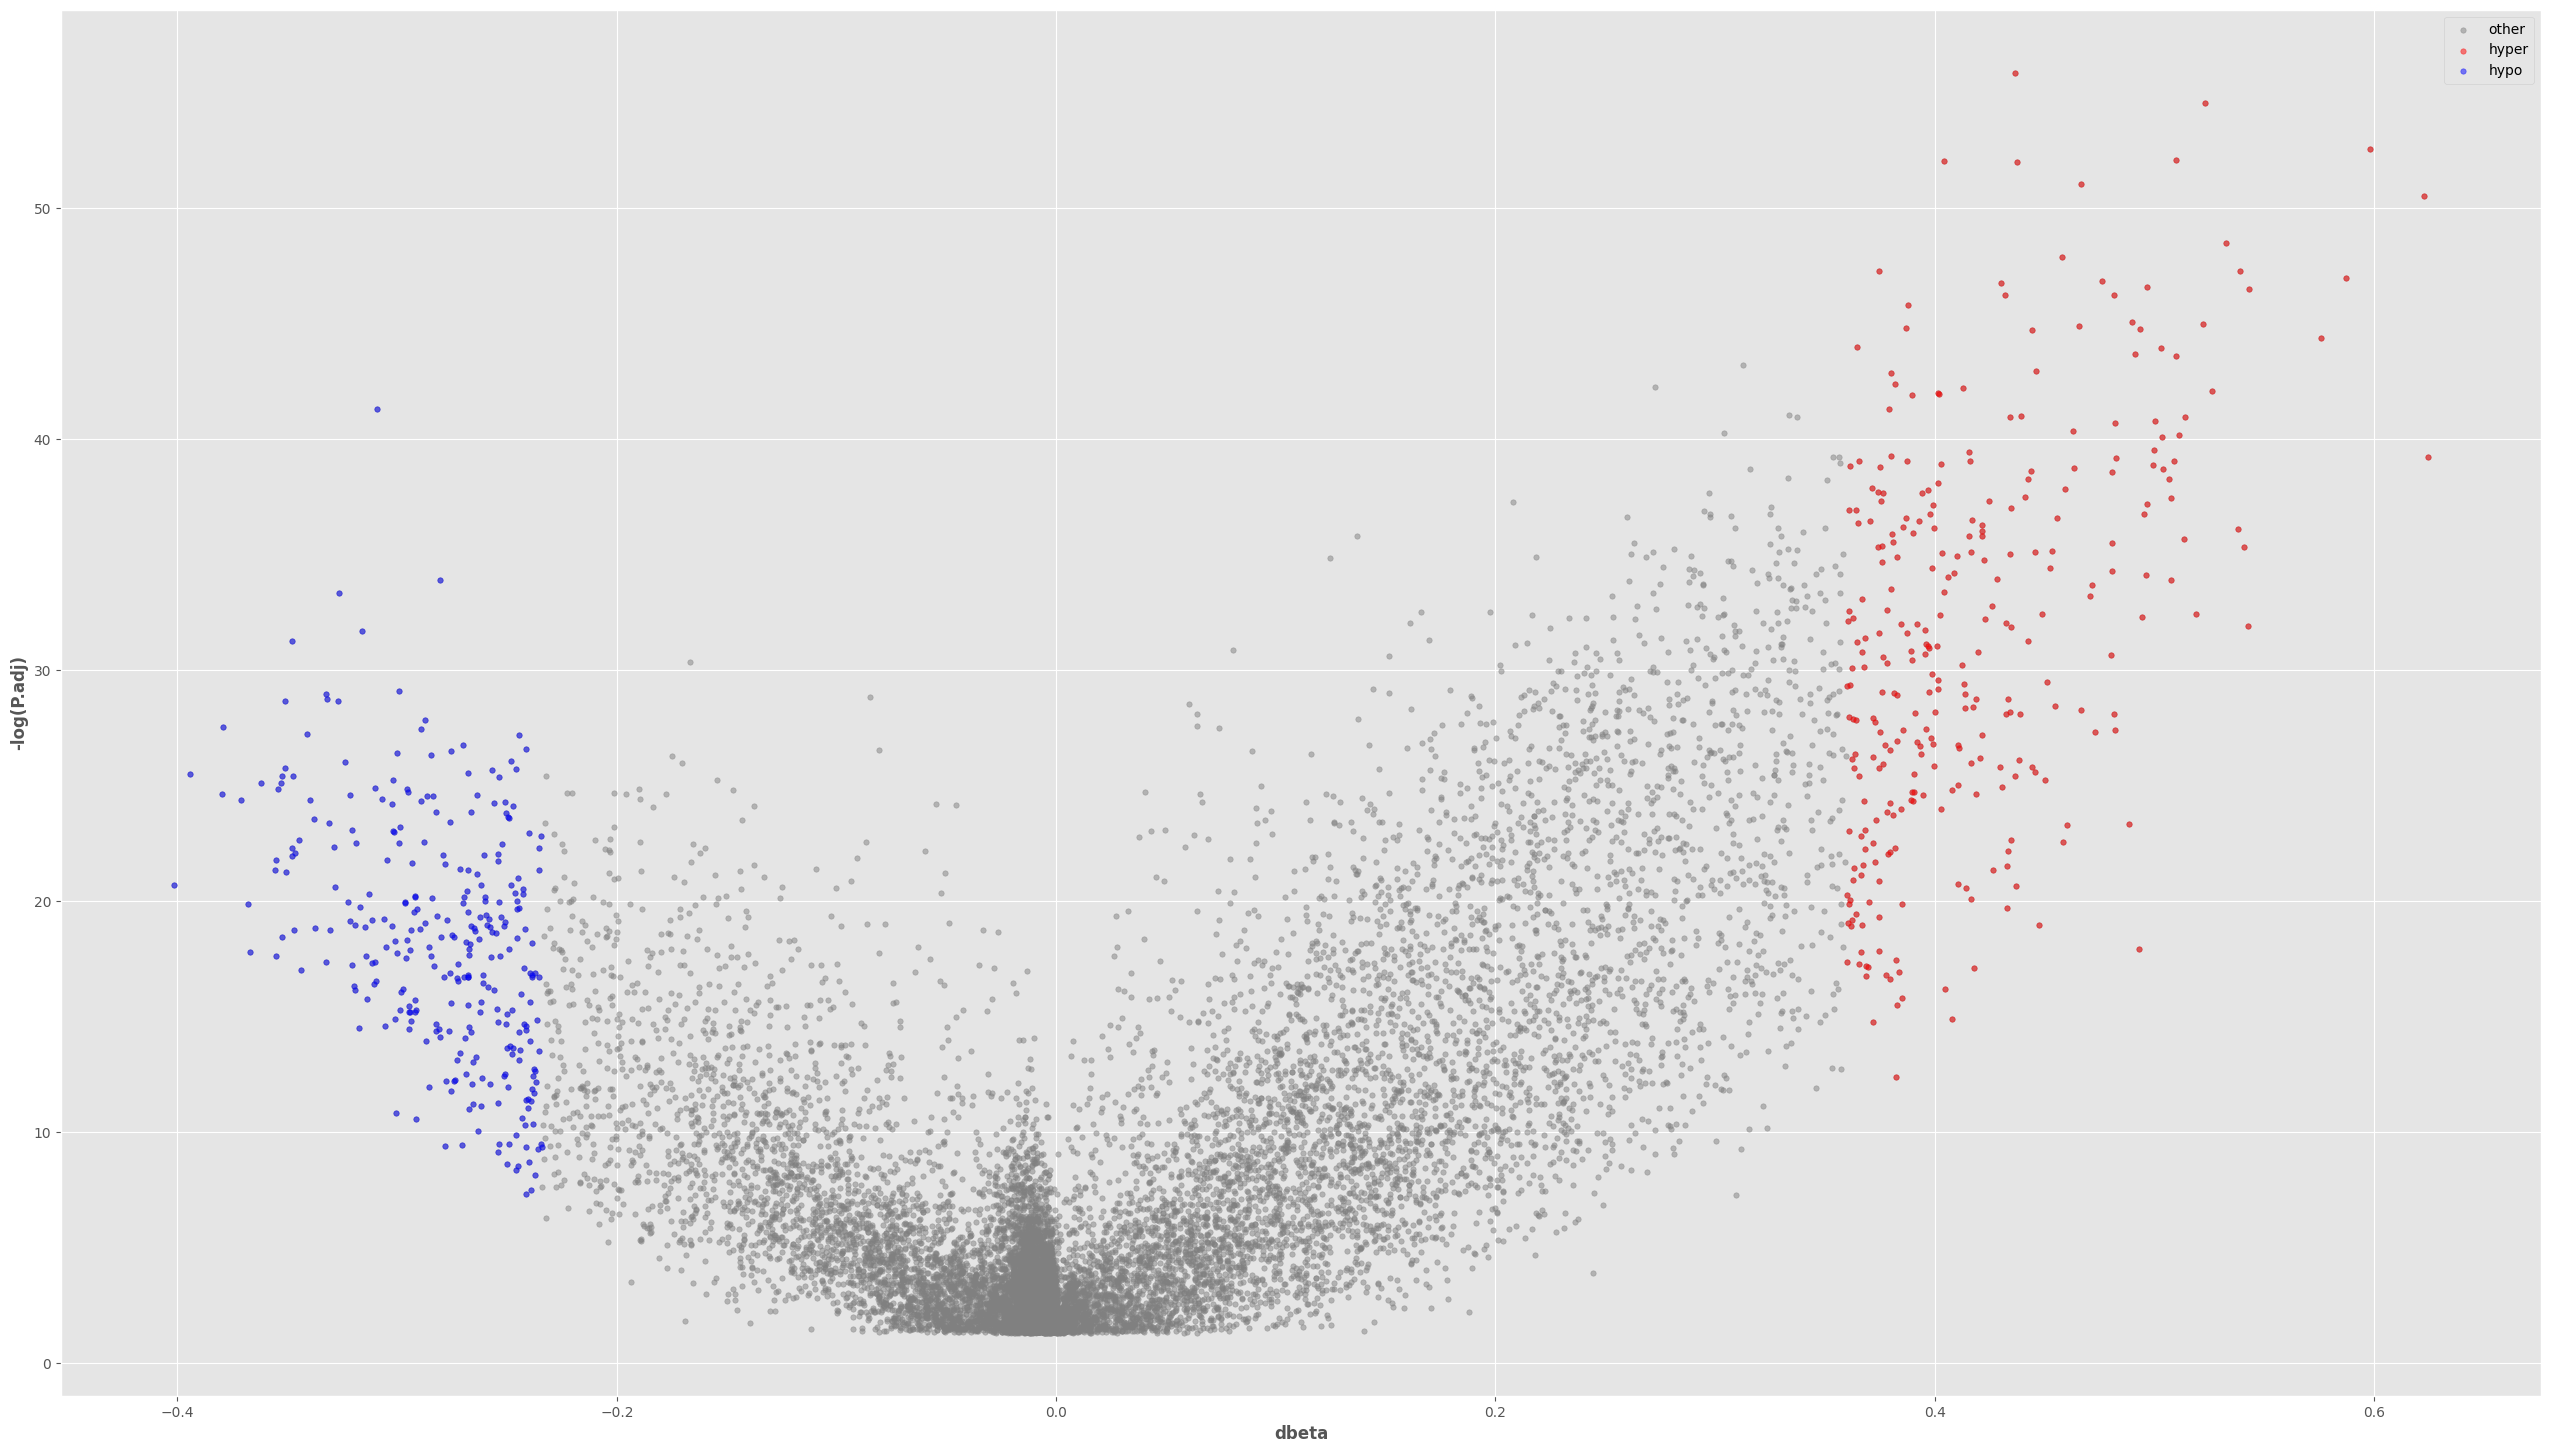

In [6]:
_sortedDf = _dbetaDf.sort_values(by='dbeta')

_hypoThreshold = _sortedDf.iloc[CHOOSE_NUM]['dbeta']
_hyperThreshold = _sortedDf.iloc[len(_sortedDf) - CHOOSE_NUM]['dbeta']

# 分hyper,hypo
_hyperDf, _hypoDf = _deltaBetaFilter.DetermineDNAm(_dbetaDf, _hyperThreshold, _hypoThreshold, _pValueThreshold)
_fig = _deltaBetaFilter.DrawVolcanoPlot(_dbetaDf, _hyperDf, _hypoDf)
plt.show()

### Calculate Cutpoint

In [7]:
_validateData = ValidateData()
_cutpointCalculator = CutpointCalculator()

# 計算切點
_cutpointDf = _cutpointCalculator.CalculateCutpoint(_betaDataDf, [_hyperDf, _hypoDf], NORMAL_NUM, ["hyper", "hypo"], "CpG", "mid")

# 驗證切點
_cutpointDf, _dataNotFind = _validateData.ValidateCutpoint(_cutpointDf, _betaValidateDataDf, VALIDATE_NORMAL_NUM)


find cutpoint: 100%|██████████| 599/599 [00:08<00:00, 74.25it/s]


### Comorbidity Gene Filter

In [8]:
_geneFilter = GeneFilter()
# 與共病基因交集
_groupDf = _geneFilter.IntersectData(_cutpointDf, _groupComorbidityList, "gene")

### Calculate Auc

draw roc: 100%|██████████| 307/307 [00:00<00:00, 1335.92it/s]


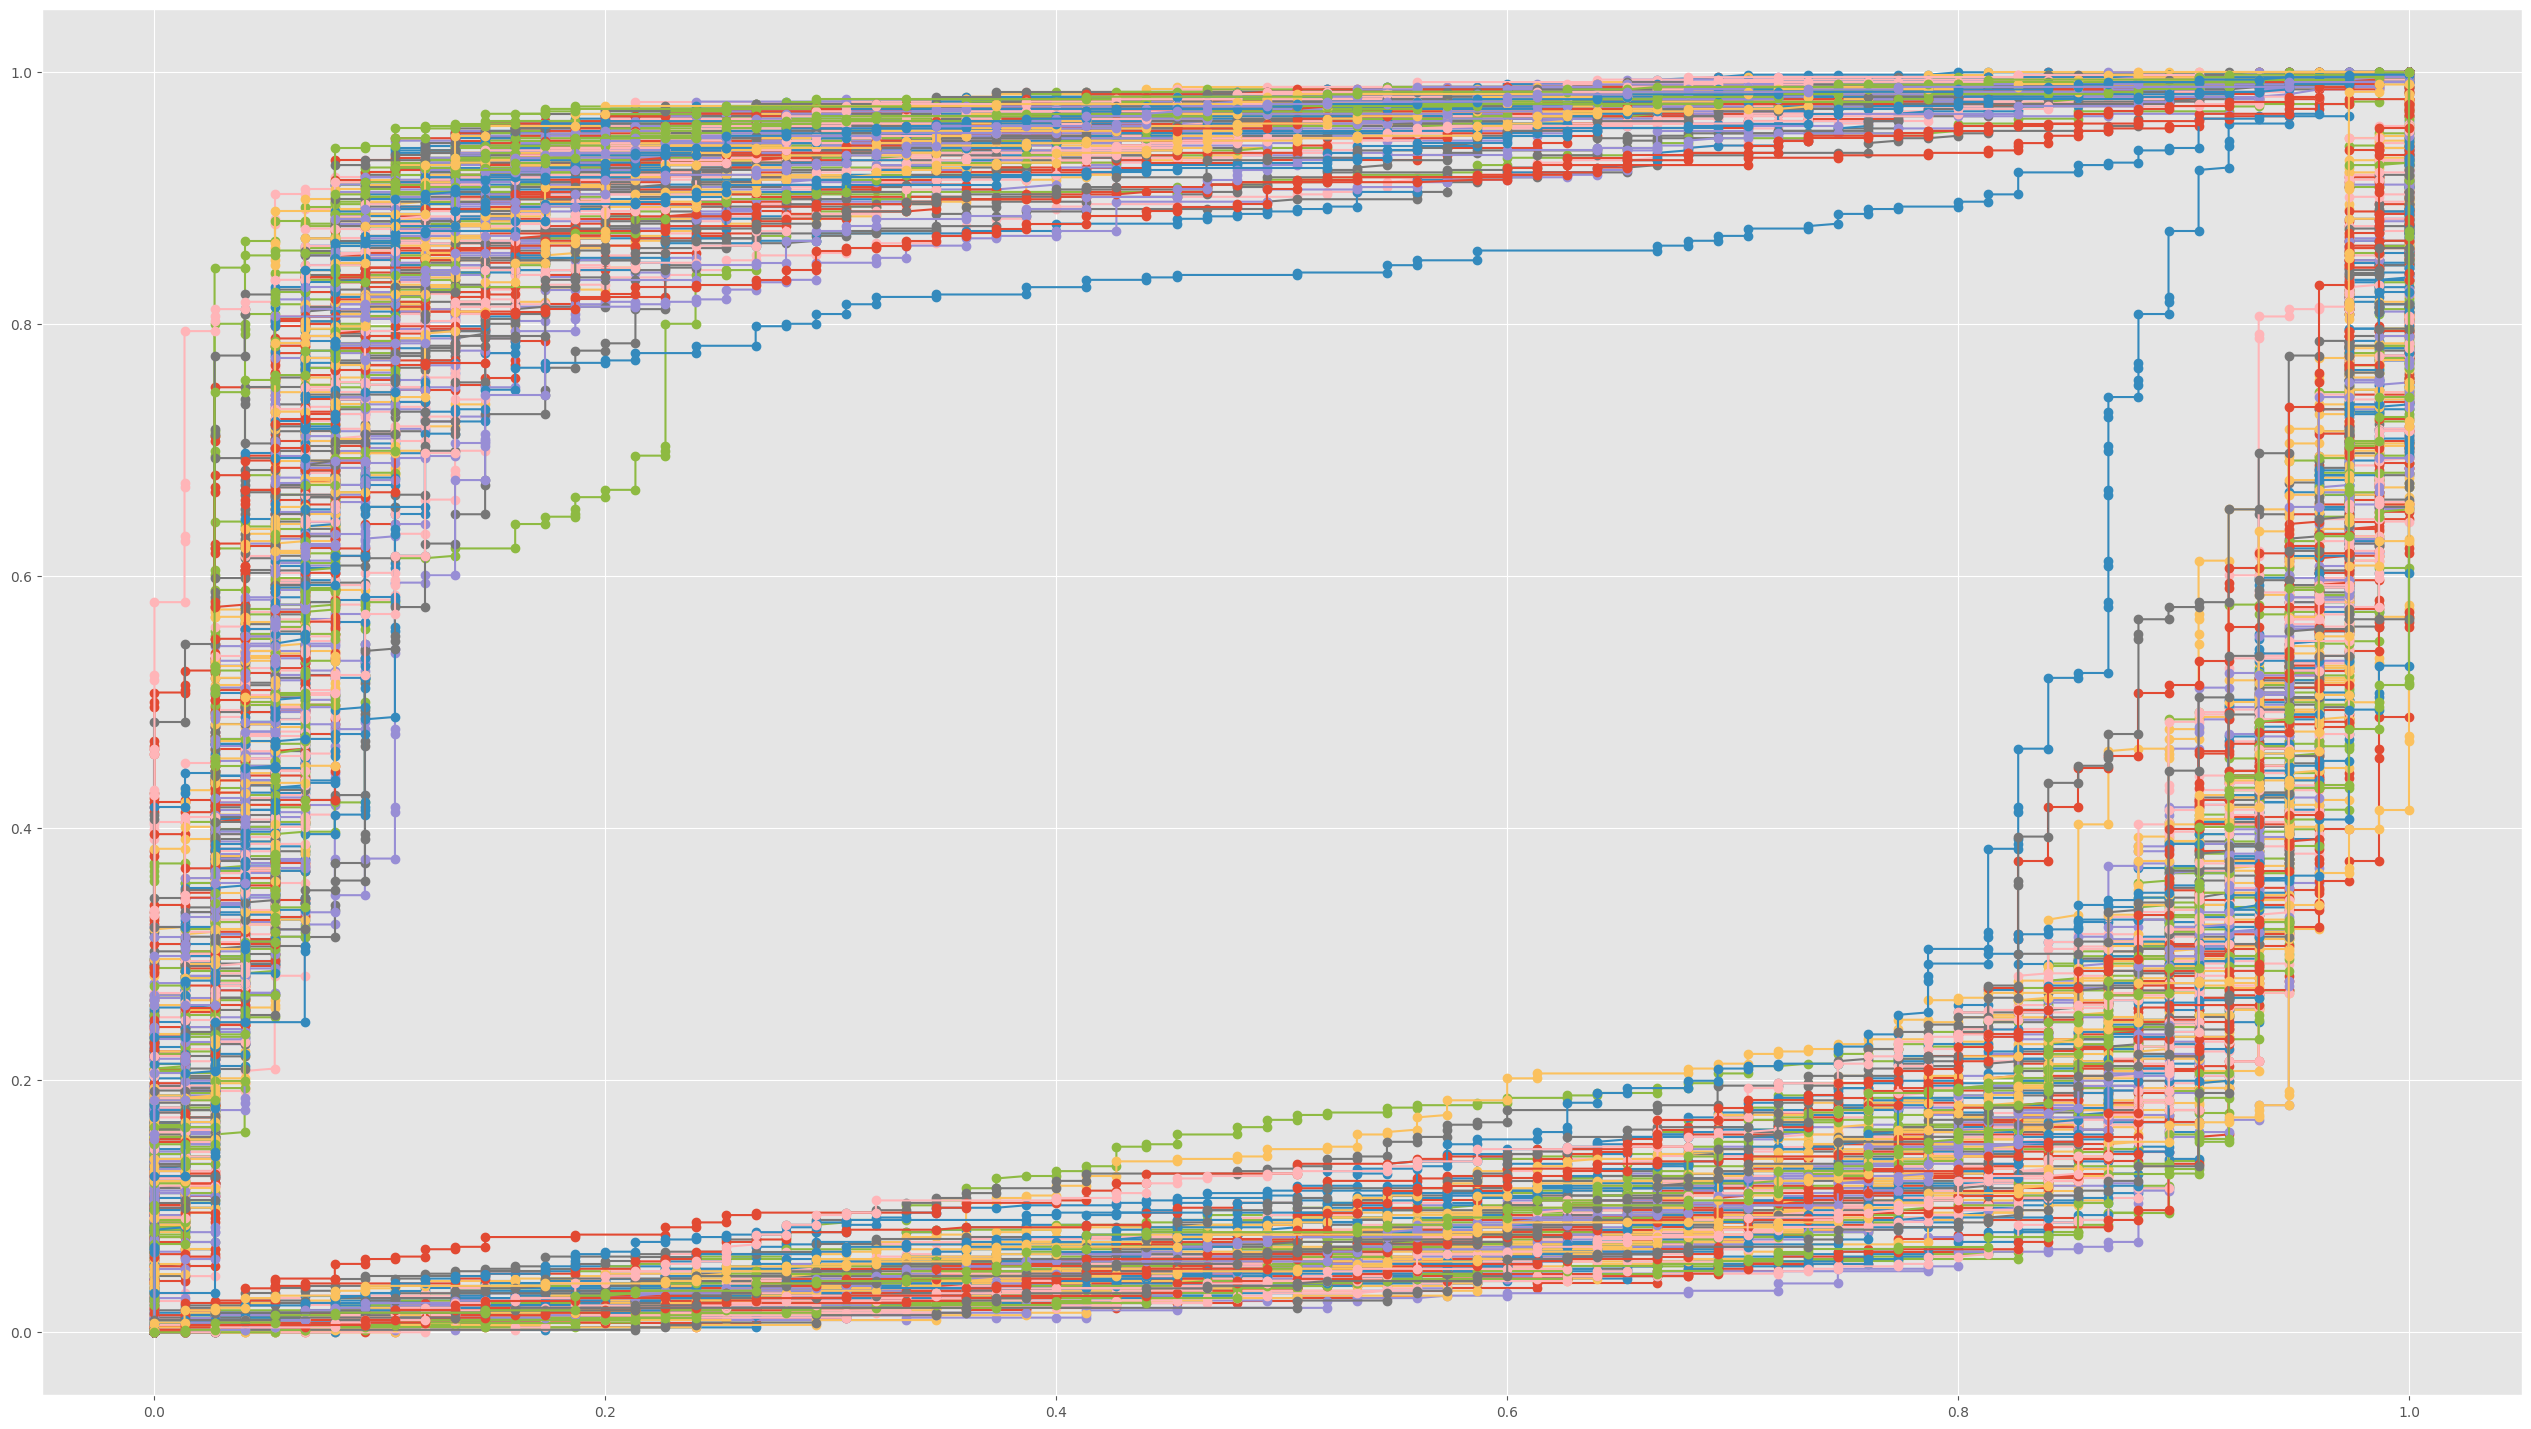

In [9]:
_aucCalculator = AucCalculator()
# 計算AUC
_aucDf = _aucCalculator.CalculateAuc(_betaDataDf, _groupDf, NORMAL_NUM)
_fig = _aucCalculator.DrawRoc(_betaDataDf, _groupDf, NORMAL_NUM)
plt.show()

FileSaver.SaveData(_aucDf, "Data/Processed/AucCalculatorData/comorbidity_group_auc.csv")

In [10]:
_geneList = _aucDf[_aucDf['DNAm'] == 'hypo']['gene'].tolist()

server = BiomartServer("http://www.ensembl.org/biomart")
interpro = server.datasets['hsapiens_gene_ensembl']
response = interpro.search({
    'filters': {
        'wikigene_name': _geneList
    },
    'attributes': [
        "external_gene_name",
        "go_id",
        "namespace_1003"
    ]
}, header = 1)

_goTermData = []
for entry in response.iter_lines():
    _goTermData.append(entry.decode('utf-8').split('\t'))
header = _goTermData[0]
_goTermData = _goTermData[1:]
_goTermData = [sublist for sublist in _goTermData if all(item != '' for item in sublist)]
_goTermDf = pd.DataFrame(_goTermData, columns=header)

In [11]:
_mfDf = _goTermDf[_goTermDf['GO domain'] == 'molecular_function']
_goTermList = _mfDf.groupby('Gene name')['GO term accession'].apply(list).reset_index().values.tolist()

S_values = [(x, GOntoSim.Semantic_Value(x, 'Baseline_LCA_avg')) for x in _goTermDf.loc[:, 'GO term accession'].tolist()]
S_values = dict(S_values)
_gosemsimDf = GOntoSim.Similarity_Matrix(_goTermList, "GOntoSim", S_values)
_gosemsimDf = pd.DataFrame(_gosemsimDf, index=_mfDf['Gene name'].unique(), columns=_mfDf['Gene name'].unique())

['ADHFE1', ['GO:0046872', 'GO:0016491', 'GO:0004022', 'GO:0047988']]
GO:0016614
GO:0043167
GO:0005488
GO:0036094
GO:0016616


ValueError: max() arg is an empty sequence

In [ ]:
_gosemsimCalculator = GosemsimCalculator()

# 分群
_geneCluster, silhouetteFig = _gosemsimCalculator.ClusterHierarchy(_gosemsimDf, "ward", range(2, 51))

plt.show()

# 合併資料
_geneCluster = _geneFilter.IntersectData(_aucDf, _geneCluster, "gene")

In [ ]:

# 挑選資料
idx_max_dbeta = _geneCluster.groupby('cluster')['dbeta'].idxmax()
idx_max_auc = _geneCluster.groupby('cluster')['auc'].idxmax()
idx_max_F1 = _geneCluster.groupby('cluster')['F1'].idxmax()

print("Dbeta Max:")
print(_geneCluster.loc[idx_max_dbeta])
print("AUC Max:")
print(_geneCluster.loc[idx_max_auc])
print("F1 Max:")
print(_geneCluster.loc[idx_max_F1])